<h1>Classify Apple Tree Diseases</h1>

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
#Model management
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
DATADIR = "/Users/Shared/plant-pathology-2021-fgvc8"
IMG_SIZE = 170

<b>importing labels table</b>
<br>Note: we are going to be working with only 3 classes: healthy, scab, powdery mildew
<br>based on customer requirements

In [4]:
df = pd.read_csv (r'/Users/Shared/plant-pathology-2021-fgvc8/train.csv')
df= df.set_index("image")
df

,labels
image,
800113bb65efe69e.jpg,healthy
8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
80070f7fb5e2ccaa.jpg,scab
80077517781fb94f.jpg,scab
800cbf0ff87721f8.jpg,complex
...,...
fffb900a92289a33.jpg,healthy
fffc488fa4c0e80c.jpg,scab
fffc94e092a59086.jpg,rust


<h2>visualization</h2>

<b>visualizing only 9 images per class</b>

In [22]:
def getExampleImages(maxImages):
    images={"healthy":[],"scab":[],"powdery_mildew":[]}
    path = os.path.join(DATADIR,"train_images")  
    for img in tqdm(os.listdir(path)): 
        name=df["labels"][img]
        if name.find("healthy")>=0:
            key="healthy"
        elif name.find("scab")>=0:
            key="scab"
        elif name.find("powdery_mildew")>=0:
            key="powdery_mildew"
        else:
            continue
        if len(images[key])>=maxImages: #certain number reached
            continue
        try:
            img_array = cv2.imread(os.path.join(path,img) ,1) 
            images[key].append(img_array) 
        except Exception as e:
            print(e)
    return images

images=getExampleImages(9)

100%|██████████| 18632/18632 [00:01<00:00, 10569.34it/s]


In [28]:
def plotLeafs(name):
    plt.figure(figsize=(16, 12))
    plt.suptitle(name, fontsize=16)
    for image_ind, image in enumerate(images[name]):
        plt.subplot(3, 3, image_ind + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

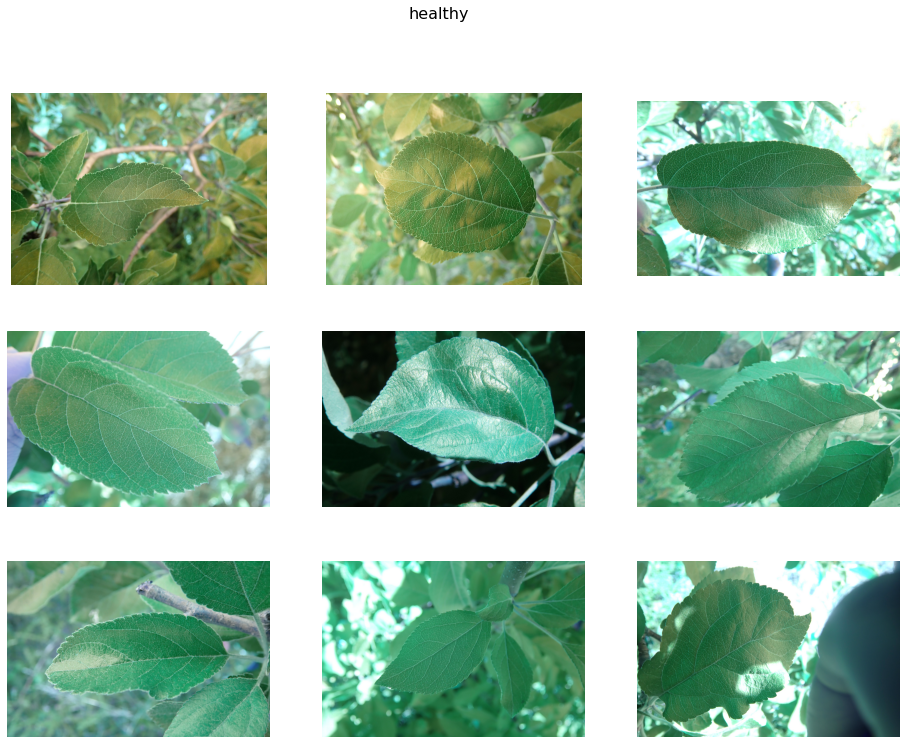

In [29]:
plotLeafs("healthy")

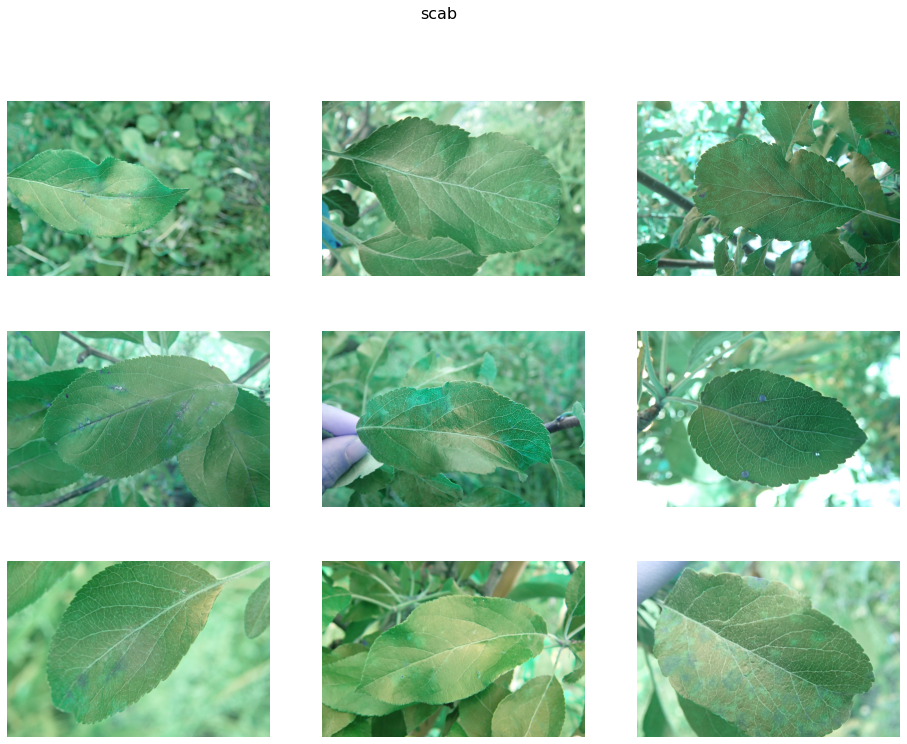

In [30]:
plotLeafs("scab")

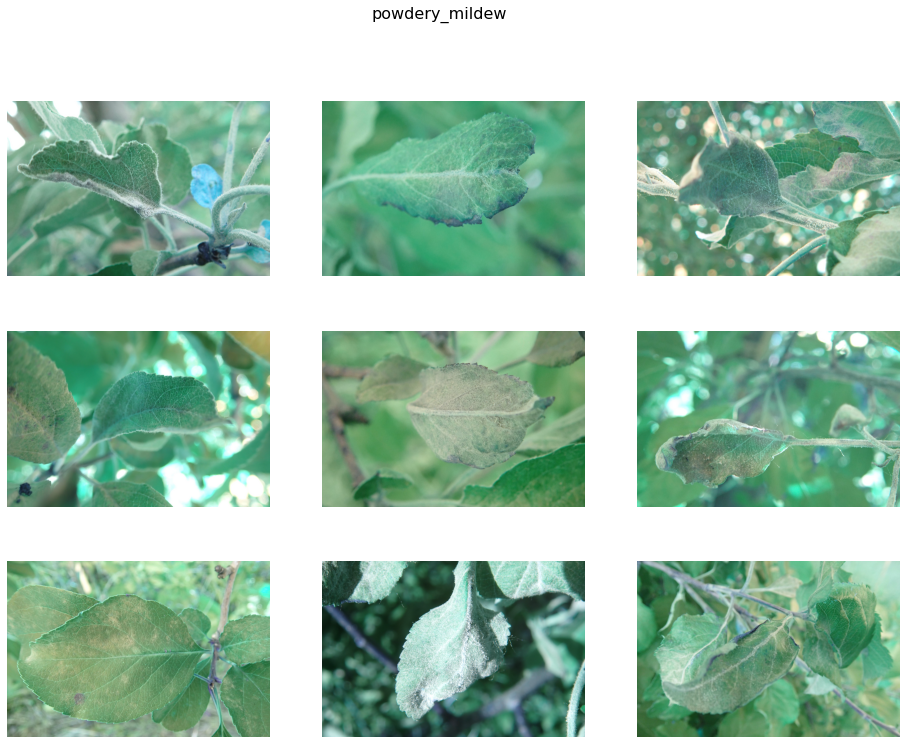

In [33]:
plotLeafs("powdery_mildew")

<h2>Training data</h2>

<b>importing data</b>

In [6]:
data = []


def create_data():
    path = os.path.join(DATADIR,"train_images")  
    for img in tqdm(os.listdir(path)): 
        name=df["labels"][img]
        #print(name)
        #print(name.find("healthy"))
        if name.find("healthy")>=0:
            class_num=[1,0,0]
        elif name.find("scab")>=0 and name.find("powdery_mildew")<0:
            class_num=[0,1,0]
        elif name.find("scab")<0 and name.find("powdery_mildew")>=0:
            class_num=[0,0,1]
        else:
            continue
        # iterate over each image per dogs and cats
        try:
            img_array = cv2.imread(os.path.join(path,img) ,1) 
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            data.append([new_array, class_num]) 
        except Exception as e:
            print(e)

create_data()

print(len(data))


100%|██████████| 18632/18632 [11:20<00:00, 27.37it/s]

11607


shuffle data for a randomized split

In [7]:
import random

random.shuffle(data)


<b>train test split</b>

In [31]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
train=data[:10000]
test=data[10000:11570]
for features,label in train:
    X_train.append(features)
    y_train.append(label)
    
for features,label in test:
    X_test.append(features)
    y_test.append(label)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)
print(X_train.shape)
print(X_test.shape)
X_train=X_train/255
X_test=X_test/255

(10000, 170, 170, 3)
(1570, 170, 170, 3)


<b>Building Convolutional Neural Network Model</b>

In [15]:
def get_CNN():
    model = keras.Sequential()
    model.add(layers.Conv2D(64,(3,3), padding="same", activation="relu", input_shape=(170,170,3)))
    model.add(layers.Conv2D(64,(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    ######
    model.add(layers.Flatten())
    model.add(layers.Dense(4096,activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(2048,activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(3, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])
    return model


In [16]:
model = get_CNN()

<b>Training Model</b>

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
def fit_model(train_x,train_y,model):
    ES = EarlyStopping(monitor='val_loss', 
                       patience=5, 
                       verbose=1,
                       min_delta=0.001,
                       restore_best_weights=True)
    model.fit(train_x,train_y,
              epochs=30,
              validation_split=0.05,callbacks = [ES])




In [18]:
print(X_train.shape)
fit_model(X_train,y_train,model)

(10000, 170, 170, 3)
Epoch 1/30
297/297 [==============================] - 468s 2s/step - loss: 0.8145 - accuracy: 0.5744 - val_loss: 0.7304 - val_accuracy: 0.6360
Epoch 2/30
297/297 [==============================] - 575s 2s/step - loss: 0.7327 - accuracy: 0.6319 - val_loss: 0.7343 - val_accuracy: 0.6520
Epoch 3/30
297/297 [==============================] - 586s 2s/step - loss: 0.7068 - accuracy: 0.6454 - val_loss: 0.8154 - val_accuracy: 0.5900
Epoch 4/30
297/297 [==============================] - 553s 2s/step - loss: 0.6751 - accuracy: 0.6683 - val_loss: 0.6294 - val_accuracy: 0.7000
Epoch 5/30
297/297 [==============================] - 547s 2s/step - loss: 0.6544 - accuracy: 0.6799 - val_loss: 0.6527 - val_accuracy: 0.6820
Epoch 6/30
297/297 [==============================] - 544s 2s/step - loss: 0.6428 - accuracy: 0.6864 - val_loss: 0.6553 - val_accuracy: 0.7060
Epoch 7/30
297/297 [==============================] - 512s 2s/step - loss: 0.6183 - accuracy: 0.7047 - val_loss: 0.6612 -

<b>Testing Model 90% accuracy</b>

In [32]:
model.evaluate(X_test,y_test)

50/50 [==============================] - 20s 391ms/step - loss: 0.2926 - accuracy: 0.9006


[0.2925834059715271, 0.9006369709968567]

<b>saving the model for later use in the application</b>

In [28]:
model.save("/Users/Shared/plant-pathology-2021-fgvc8/model_v3")

INFO:tensorflow:Assets written to: /Users/Shared/plant-pathology-2021-fgvc8/model_v3/assets


INFO:tensorflow:Assets written to: /Users/Shared/plant-pathology-2021-fgvc8/model_v3/assets
